# traer data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
!pwd

/content


In [3]:
twitter_reddit = pd.read_csv('/twitter_reddit_text.csv')
twitter_reddit.head()
twitter_reddit['text'] = twitter_reddit.clean_text
twitter_reddit.drop(columns=['clean_text','Unnamed: 0'] , inplace=True)
twitter_reddit = twitter_reddit[['text' , 'label']]

In [4]:
twitter_reddit.head()

,text,label
0,lay bed hour point back pain get work minut cl...,1
1,dlitedaili dont play wouldnt want anyth world,0
2,rewebcoach hey handsom time get day go,0
3,get readi tenni maryyi,0
4,hear song band almost never play favourit radi...,0


In [5]:
transcriptions = pd.read_csv('/transcriptions_targets_lemmatized.csv')
transcriptions.head()
transcriptions['text'] = transcriptions.lemmatized_text
transcriptions['label'] = transcriptions.PHQ8_Binary
transcriptions = transcriptions.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0','clean_text',
       'lemmatized_text', 'PHQ8_Binary'])

In [6]:
transcriptions.head()

,text,label
0,fine angeles california family friend mixture ...,0.0
1,moscow family moved moved eventually college l...,0.0
2,connecticut actor moved san francisco moved at...,0.0
3,originally angeles weather family moved lot cu...,1.0
4,angeles lot thing love beach love love sunny t...,1.0


In [7]:
reddit_uncored = pd.read_csv('/reddit_uncored2.csv')
transcriptions_uncored = pd.read_csv('/transcription_uncored.csv')

transcriptions_uncored['text'] = transcriptions_uncored.uncored
transcriptions_uncored['label'] = transcriptions_uncored.PHQ8_Binary
transcriptions_uncored.drop(columns=  ['Unnamed: 0' , 'uncored','Unnamed: 0.1','PHQ8_Binary'] , inplace=True)

In [8]:


reddit_uncored['text'] = reddit_uncored.uncored
reddit_uncored.drop(columns= ['uncored', 'Unnamed: 0'], inplace=True)

reddit_uncored.head()

,text,label
0,i recently went through a breakup and she said...,1
1,i do not know how to navigate these 0 not th...,1
2,so i have been with my bf for 0 and he alrea...,1
3,i am so 0 of this just when i think i can 0...,0
4,i have been severly 0 since i was till this ...,1


In [9]:
transcriptions_uncored.head()

,text,label
0,i am 0 how about yourself i am from los 0 ...,0.0
1,um 0 um my 0 0 to the u s and then i 0 ...,0.0
2,yes okay 0 um to be an 0 well i 0 to 0 ...,0.0
3,yes i am okay 0 i am from here originally lo...,1.0
4,yes i am okay here in los 0 there is a 0 o...,1.0


In [10]:
transcriptions_reddit = transcriptions.merge(twitter_reddit , how='outer')

In [11]:
transcriptions_reddit['label']= transcriptions_reddit.label.astype(int)

In [12]:
transcriptions_reddit= transcriptions_reddit.sample(n=  6000, random_state = 42)

In [13]:
transcriptions_reddit.reset_index(drop=True, inplace=True)

In [14]:
transcriptions_reddit

,text,label
0,tini studio apart depress week well entir life...,1
1,lucki enough parent forc career yet howev rn b...,1
2,mikalaaaaaaaa weed help depress tho emoji man ...,1
3,wallflowergrow that cool,0
4,mention friend wish pair float eyebal world bo...,1
...,...,...
5995,game time shotyy gunna test,0
5996,learn song guitar,0
5997,want win throwboy pillow retweet chanc win tod...,0
5998,hello look support anyon kind enough read post...,1


In [15]:
transcriptions_reddit_val=transcriptions_reddit.loc[:999]

transcriptions_reddit_sample = transcriptions_reddit.loc[1000:]

In [16]:
transcriptions_reddit_val

,text,label
0,tini studio apart depress week well entir life...,1
1,lucki enough parent forc career yet howev rn b...,1
2,mikalaaaaaaaa weed help depress tho emoji man ...,1
3,wallflowergrow that cool,0
4,mention friend wish pair float eyebal world bo...,1
...,...,...
995,mani famou peopl want learn english better,0
996,hi gf suffer realli bad depress anxieti whole ...,1
997,halu dinner second time week,0
998,go ali willetta parti,0


In [17]:
uncored = reddit_uncored.merge(transcriptions_uncored, how='outer')

In [18]:
uncored['label'] = uncored.label.astype(int)

In [19]:
uncored_sample = uncored.sample(n = 5000  , random_state = 42)

In [20]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## train test split


In [21]:
#split for the data which is not uncored

X =transcriptions_reddit_sample.text
y = transcriptions_reddit_sample.label
X_train, X_test, y_train, y_test = train_test_split(X , y ,test_size = 0.3 )


In [22]:
#add uncored data to the training set
X_train = pd.concat([X_train,uncored_sample.text])
y_train = pd.concat([y_train , uncored_sample.label])

In [23]:
print('length of X_train',len(X_train), 'length of X_test',len(X_test), 'length of y_train',len(y_train), 'length of y_test',len(y_test))

length of X_train 8500 length of X_test 1500 length of y_train 8500 length of y_test 1500


In [24]:
#validation 

X_val = transcriptions_reddit_val.text
y_val = transcriptions_reddit_val.label

## word tokenize and word 2 vec

In [25]:


X_train = [word_tokenize(str(_)) for _ in X_train]
X_test = [word_tokenize(str(_)) for _ in X_test]
X_val = [word_tokenize(str(_)) for _ in X_val]


In [26]:


# This line trains an entire embedding for the words in your train set
word2vec = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=5)

# data embedding

## embed data

In [27]:
def embed_sentence(word2vec, sentence):
    # $CHALLENGIFY_BEGIN
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

In [28]:
def embedding(word2vec, sentences):
    # $CHALLENGIFY_BEGIN
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed
    # $CHALLENGIFY_END
    
X_train = embedding(word2vec, X_train)
X_test = embedding(word2vec, X_test)
X_val= embedding(word2vec, X_val)

## pad data

In [29]:
'''X_train_pad = pad_sequences(X_train, dtype='float', padding='post')
X_test_pad = pad_sequences(X_test, dtype='float', padding='post')'''

"X_train_pad = pad_sequences(X_train, dtype='float', padding='post')\nX_test_pad = pad_sequences(X_test, dtype='float', padding='post')"

In [30]:
print('number of train texts: ' ,len(X_train))
X_train[3].shape[0]

number of train texts:  8500


141

In [31]:
text_word_lengths = [X_train[i].shape[0] for i in np.arange(len(X_train))]
text_word_lengths_test = [X_test[i].shape[0] for i in np.arange(len(X_test))]

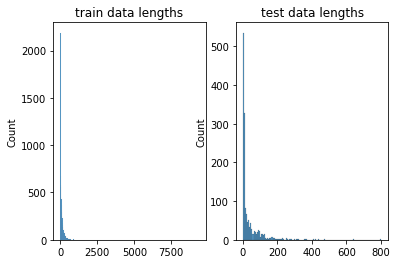

In [32]:
plt.figure()
plt.subplot(1,2,1)
plt.title('train data lengths')
sns.histplot(text_word_lengths)
plt.subplot(1,2,2)
plt.title('test data lengths')
sns.histplot(text_word_lengths_test)

In [33]:
#cortamos en 1000 words

X_train_pad = pad_sequences(X_train, dtype='float', padding='post', maxlen= 200,truncating= 'pre')
X_test_pad = pad_sequences(X_test, dtype='float', padding='post', maxlen = 200 , truncating = 'pre')
X_val_pad = pad_sequences(X_val, dtype='float', padding='post', maxlen = 200 , truncating = 'pre')

# the model

## baseline score

In [34]:
from sklearn.metrics import accuracy_score

unique, counts = np.unique(y_train, return_counts=True)
counts = dict(zip(unique, counts))
print('Number of labels in train set', counts)

y_pred = 0 if counts[0] > counts[1] else 1

print('Baseline accuracy: ', accuracy_score(y_test, [y_pred]*len(y_test)))

Number of labels in train set {0: 4184, 1: 4316}
Baseline accuracy:  0.5053333333333333


## first neural network

In [35]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(100, activation='tanh', return_sequences=True))
    model.add(layers.LSTM(100, activation='tanh', return_sequences=True))
    model.add(layers.LSTM(50, activation='tanh'))

    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(25, activation='tanh'))

    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(5, activation='tanh'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy', 'AUC','Precision','Recall'])
    
    return model

model = init_model()

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3, restore_best_weights=True)

history_fit = model.fit(X_train_pad, y_train.values, 
          batch_size = 256,
          epochs=100,
        validation_data= (X_val_pad,y_val.values) ,
          callbacks=[es],
          verbose = 1
         )

Epoch 1/100
34/34 [==============================] - 74s 2s/step - loss: 0.6033 - accuracy: 0.6494 - auc: 0.7150 - precision: 0.6522 - recall: 0.6631 - val_loss: 0.3244 - val_accuracy: 0.9140 - val_auc: 0.9601 - val_precision: 0.9012 - val_recall: 0.9236
Epoch 2/100
34/34 [==============================] - 48s 1s/step - loss: 0.5409 - accuracy: 0.6852 - auc: 0.7829 - precision: 0.6945 - recall: 0.6784 - val_loss: 0.2134 - val_accuracy: 0.9520 - val_auc: 0.9700 - val_precision: 0.9719 - val_recall: 0.9277
Epoch 3/100
34/34 [==============================] - 51s 2s/step - loss: 0.5124 - accuracy: 0.7011 - auc: 0.8033 - precision: 0.7134 - recall: 0.6874 - val_loss: 0.1876 - val_accuracy: 0.9500 - val_auc: 0.9718 - val_precision: 0.9822 - val_recall: 0.9132
Epoch 4/100
34/34 [==============================] - 40s 1s/step - loss: 0.5010 - accuracy: 0.7079 - auc: 0.8111 - precision: 0.7104 - recall: 0.7171 - val_loss: 0.1536 - val_accuracy: 0.9650 - val_auc: 0.9811 - val_precision: 0.9746 -

In [37]:
import joblib
joblib.dump(model, 'rnn_alldata3.sav')

INFO:tensorflow:Assets written to: ram://c1180760-fcff-4a9a-997b-c20ed8e4d794/assets


INFO:tensorflow:Assets written to: ram://c1180760-fcff-4a9a-997b-c20ed8e4d794/assets


['rnn_alldata3.sav']

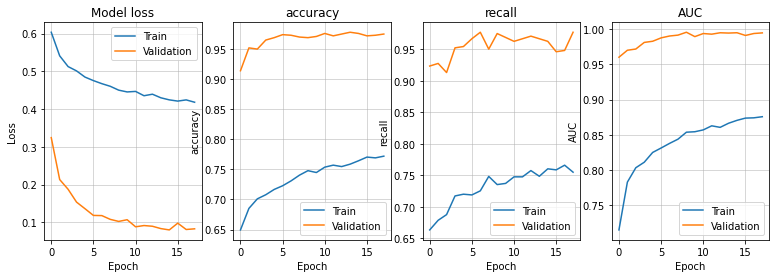

In [38]:
def plot_loss_mae(history):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    #ax1.set_ylim(ymin=0, ymax=200)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)    
    
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('Epoch')
    #ax2.set_ylim(ymin=0, ymax=20)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)    

    
    
    ax3.plot(history.history['recall'])
    ax3.plot(history.history['val_recall'])
    ax3.set_title('recall')
    ax3.set_ylabel('recall')
    ax3.set_xlabel('Epoch')
    #ax3.set_ylim(ymin=0, ymax=20)
    ax3.legend(['Train', 'Validation'], loc='best')
    ax3.grid(axis="x",linewidth=0.5)
    ax3.grid(axis="y",linewidth=0.5)
    
    ax4.plot(history.history['auc'])
    ax4.plot(history.history['val_auc'])
    ax4.set_title('AUC')
    ax4.set_ylabel('AUC')
    ax4.set_xlabel('Epoch')
    #ax4.set_ylim(ymin=0, ymax=20)
    ax4.legend(['Train', 'Validation'], loc='best')
    ax4.grid(axis="x",linewidth=0.5)
    ax4.grid(axis="y",linewidth=0.5)
    
    plt.show()

plot_loss_mae(history_fit)

In [39]:
evaluation = model.evaluate(X_test_pad , y_test.values , verbose = 1 , return_dict=True)

47/47 [==============================] - 3s 67ms/step - loss: 0.1289 - accuracy: 0.9647 - auc: 0.9834 - precision: 0.9770 - recall: 0.9525


In [40]:
evaluation

{'accuracy': 0.9646666646003723,
 'auc': 0.9834486842155457,
 'loss': 0.12885993719100952,
 'precision': 0.9769959449768066,
 'recall': 0.9525066018104553}

In [44]:
transcriptions_reddit_val.text.values

array(['tini studio apart depress week well entir life e wave feel depress lift apart mess give anxieti attack look motiv clean go get depress slump get clean need advic apart',
       'lucki enough parent forc career yet howev rn bare count wake bare minimum everyday can not even sleep normal wake alarm know ever go abl live sort product life st point context take medic sleep night still can not fall asleep earli morn can not wake reason time tri almost plete incoher sleep medic also form antidepress choos healthi amount sleep depress med feel like plete failur either way scare depress episod anxieti attack whenev anyth day feel abl wake time get feel capabl adult life',
       'mikalaaaaaaaa weed help depress tho emoji man shrug medium skin tone',
       'wallflowergrow that cool',
       'mention friend wish pair float eyebal world bodi observ everyth said alreadi told feel perceiv especi horrifi thought reason even know brought sudden phobia mani time caught think wish could disapp